In [1]:
import sys
import subprocess
import pkg_resources

In [2]:
import torch
torch.cuda.is_available()


True

In [3]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import gc #Garbage collector
from tqdm import tqdm # Progress bar

In [4]:
# TAMAÑO DE LAS IMÁGENES
IMG_SIZE = (256, 256)

# DIMENSIÓN DE LA CAPA DE TEMPLATES DE LOS model_trainedS
TEMPLATE_SIZE = 256

# Se establece el número de épocas
EPOCHS = 25

# Se establece el tamaño de batch
BATCH_SIZE = 32#64

# Se establece el learning rate inicial
LEARNING_RATE = 0.0005

# Directorio que contiene la base de datos sobre la que vamos a realizar el entrenamiento
MAIN_DIR ="./BD-461/Especificidad M/"

# Numero de clases a diferenciar en el clasificador
CLASES = 34

In [5]:
# Se engloban las transformaciones necesarias para los conjuntos de train y test
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    # Se incluye data augmentation para prevenir el overfitting y poder conseguir unos pesos con un mayor accuracy en validación y test
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [6]:
train_dataset = torchvision.datasets.ImageFolder(
    root = MAIN_DIR + "train",
    transform = train_transform
    )

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

val_dataset = torchvision.datasets.ImageFolder(
    root = MAIN_DIR + "val",
    transform = train_transform
    )

val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
ETIQUETAS = train_dataset.classes

Dividimos entre train y val

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


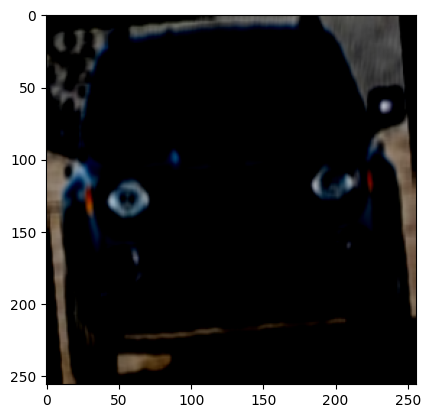

Label: Jeep


In [7]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
img = np.swapaxes(img,0,2)
img = np.swapaxes(img, 0,1)
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {ETIQUETAS[label]}")

In [8]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device {device}.")

Training on device cuda.


In [9]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
#model.classifier = nn.Linear(model.classifier.in_features,CLASES)
model.fc = nn.Linear(model.fc.in_features, CLASES)
#model = LeNet5(19)
#model.eval esto se ha quitado sin probar

Using cache found in /home/andres/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/andres/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/andres/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.10.0
/home/andres/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/andres/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other t

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

In [11]:
def validate(model, train_dataloader, val_dataloader, device):
    for name, loader in [("train", train_dataloader), ("val", val_dataloader)]:
        correct = 0
        total = 0
        
        model.eval() # Ponemos nuestrom model_trained en modo evaluación

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy in {}: {:.2f}".format(name , correct / total))
    return (correct/total)

In [12]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_dataloader):
    model = model.to(device=device)
    best_acuracy = float('-inf')
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        model.train() # Modo train
        
        for imgs, labels in train_dataloader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            logits = model(imgs)
            loss = loss_fn(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 5 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_dataloader)))
            acuracy_val = validate(model, train_dataloader, val_dataloader, device)
            if(acuracy_val < best_acuracy):
                print("Entrenamiento detenido por early stopping, se estaba sobreentrenando el modelo")
                break
            else:
                best_acuracy = acuracy_val
        if(acuracy_val < best_acuracy):
            break

    return model

In [15]:
model_trained = training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
)

KeyboardInterrupt: 

Guardamos los pesos de la red para poder utilizarla sin reentrenarla

In [14]:
import os
model_path = "./models/"
if not os.path.exists(model_path):
    os.mkdir(model_path)

torch.save(model_trained.state_dict(), model_path + 'resnet50-EspecificidadM.pt')
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Procedemos al testeo del modelo entrenado

In [16]:
test_dataset = torchvision.datasets.ImageFolder(
    root = MAIN_DIR + "test",
    transform=test_transform
    )

test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

modelo = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
modelo.fc = nn.Linear(modelo.fc.in_features, CLASES)
pesos = torch.load('./models/resnet50-EspecificidadM.pt',map_location='cuda')
modelo.load_state_dict(pesos)
modelo.to(device)
modelo.eval()
#model_trained.eval()

correct = 0
total = 0
true_labels = []
predicted_labels = []

num_images_to_display = 10
subset_images = []
subset_labels_true = []
subset_labels_pred = []


with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = modelo(images)
        _, predicted = torch.max(outputs.data, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Se obtiene un subconjunto de imágenes para mostrar junto a sus etiquetas
        subset_images.extend(images[:num_images_to_display].cpu())
        subset_labels_true.extend(labels[:num_images_to_display].cpu().numpy())
        subset_labels_pred.extend(predicted[:num_images_to_display].cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

accuracy = 100 * correct / total
print('Precisión en el conjunto de prueba: {}%'.format(accuracy))

# Calcular métricas
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print('Precisión: {:.2f}%'.format(accuracy * 100))
print('Precisión promedio: {:.2f}%'.format(precision * 100))
print('Exhaustividad promedio: {:.2f}%'.format(recall * 100))
print('Puntuación F1 promedio: {:.2f}%'.format(f1 * 100))

# Generar matriz de confusión
confusion_mtx = confusion_matrix(true_labels, predicted_labels)
print('Matriz de confusión:')
print(confusion_mtx)

# Generar informe de clasificación
print('Informe de clasificación:')
print(classification_report(true_labels, predicted_labels))

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.10.0
/home/andres/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/andres/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Precisión en el conjunto de prueba: 97.74520856820745%
Precisión: 97.75%
Precisión promedio: 97.54%
Exhaustividad promedio: 97.75%
Puntuación F1 promedio: 97.59%
Matriz de confusión:
[[11  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0 48 ...  0  0  0]
 ...
 [ 0  0  0 ... 42  1  0]
 [ 0  0  0 ...  0 70  0]
 [ 0  0  0 ...  1  0 12]]
Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00        48
           3       1.00      1.00      1.00        83
           4       0.67      0.67      0.67         3
           5       0.98      1.00      0.99        55
           6       0.00      0.00      0.00         1
           7       1.00      0.90      0.95        21
           8       1.00      1.00      1.00         1
           9       1.00      0.96      0.98        23
          10       0.96      0.94      0

/home/andres/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andres/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andres/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andres/.local/lib/python3.10/site-packages/s

In [20]:
subset_images = torch.stack(subset_images)
subset_labels_true = np.array(subset_labels_true)
subset_labels_pred = np.array(subset_labels_pred)

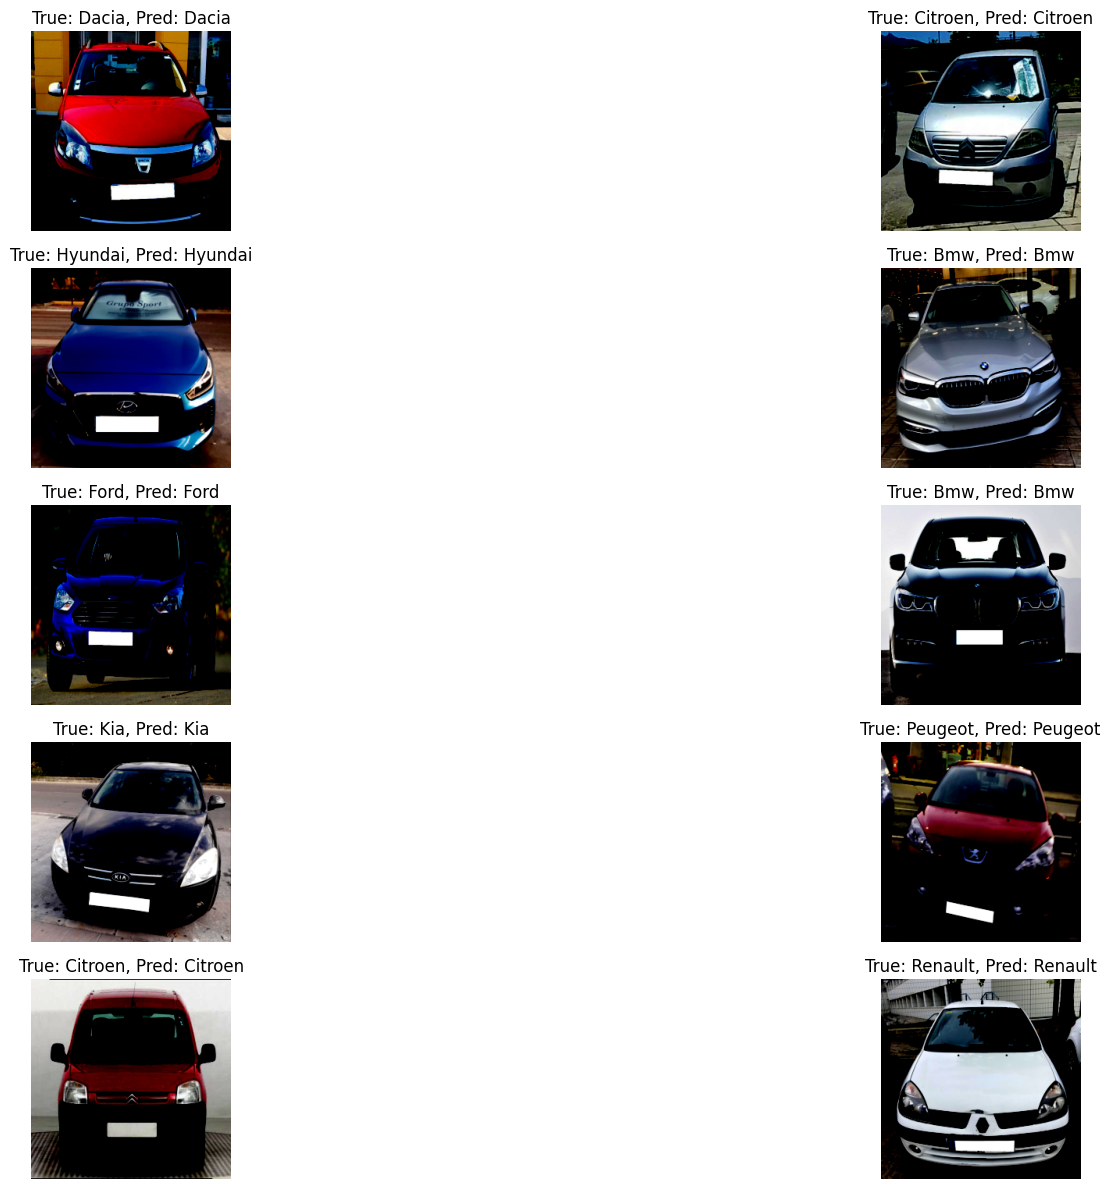

In [21]:
# Mostrar las imágenes junto con las etiquetas reales y predichas
fig, axs = plt.subplots(5, 2, figsize=(24, 12))

for i in range(num_images_to_display):
    image = subset_images[i]
    label_true = ETIQUETAS[subset_labels_true[i]]
    label_pred = ETIQUETAS[subset_labels_pred[i]]
    
    image = np.transpose(image, (1, 2, 0))
    image = np.clip(image, 0, 1)  # Ajustar los valores de píxel al rango [0, 1]
    
    axs[i % 5, i // 5].imshow(image)
    axs[i % 5, i // 5].axis('off')
    axs[i % 5, i // 5].set_title(f'True: {label_true}, Pred: {label_pred}')

plt.tight_layout()
plt.show()

Ejemplo Con foto aleatoria de internet de un toyota que nos hace ver como el modelo es igual a los 4x4 presentes en la base de datos de suzuki permitiéndonos ver como esas características distintivas pueden ser copiadas entre marcas

Audi


((0.31515357, 2, 'Audi'),
 (0.18091948, 25, 'Peugeot'),
 (0.088708505, 15, 'Jeep'),
 (0.05825057, 32, 'Volkswagen'),
 (0.05810076, 29, 'Suzuki'))

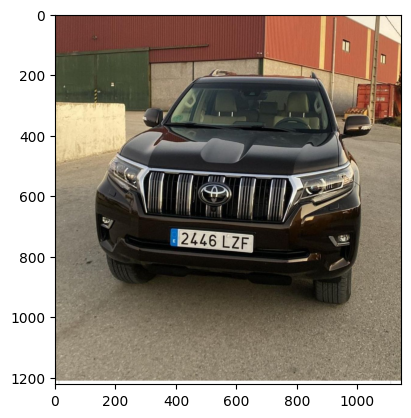

In [22]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

image_path = '/home/andres/Descargas/WhatsApp Image 2023-06-17 at 18.09.05.jpeg'
image = Image.open(image_path).convert('RGB')
input_image = test_transform(image).unsqueeze(0).to(device)

outputs = modelo(input_image)
probs = F.softmax(outputs, dim=1)
probs5 = probs.topk(5)

_, predicted = torch.max(outputs.data, 1)

print(ETIQUETAS[int(predicted[:1].cpu().numpy())])
plt.imshow(image)

tuple((p,c, ETIQUETAS[c]) for p, c in zip(probs5[0][0].detach().cpu().numpy(), probs5[1][0].detach().cpu().numpy()))

Podemos ver como a pesar de ser una imagen de un vehículo Toyota, las predicciones no contienen ninguna probabilidad de que sea de dicha marca.

Esto es así debido a 2 motivos principales, el primero de ellos es la ausencia de ejemplos e entrenamiento sobre este modelo, la segunda el plagio entre marcas que hace que sea dificil distinguir por ejemplo modelos tipo 4x4 entre marcas como Toyota, Suzuki..